In [1]:
import os, sys, warnings
import numpy as np, matplotlib.pyplot as plt
from sequentia import *
from tqdm.auto import tqdm

# Silence TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import utility functions and classes
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import *
from lstm import LSTMClassifier

# Filter warnings
warnings.filterwarnings('ignore')

# ggplot style
plt.style.use('ggplot')

# Set seed for reproducible randomness
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed=seed)

In [2]:
gestures_map = {
    'nd': 'nod',
    'mnd': 'multiple nods',
    'fu': 'face-up',
    'fd': 'face-down',
    'sh': 'shake',
    't': 'turn',
    'ti': 'tilt'
}

gestures = list(gestures_map.keys())

In [3]:
fields = ['Rx', 'Ry', 'Rz']

In [4]:
# Containers to store classifiers and results
clfs, results = {}, {'hmm': {}, 'knn': {}, 'lstm': {}}

In [5]:
# Load the MoCap dataset
loader = MoCapLoader(normalized=False)
X, y = loader.load(fields)

## Dataset splits

Create a stratified 65-20-15 training, validation and test set split.

In [6]:
# Create a stratified training, validation and test set split (65-20-15)
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X, y, random_state=rng, stratify=True)

Training set size: 841
Validation set size: 258
Test set size: 196


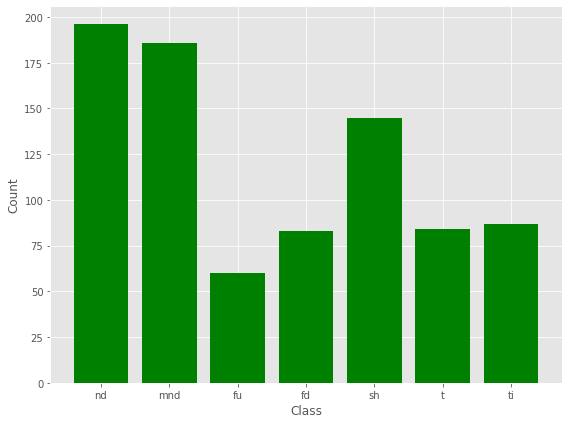

In [7]:
# MoCap dataset class counts (training set)
show_class_counts(y_train, gestures, title=None)

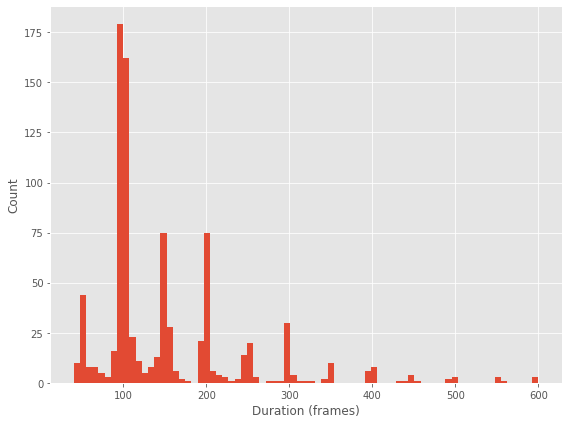

In [8]:
# Histogram of MoCap dataset gesture durations (training set)
show_durations(X_train, bins=75, title=None)

## Preprocessing

In [9]:
# Create a preprocessing pipeline
pre = Preprocess([
    Filter(window_size=10, method='median'),
    BinDownsample(bin_size=50, method='decimate'),
    Center()
])
pre.summary()

             Preprocessing summary:            
1. Filter
   Median filtering with window-size 10
-----------------------------------------------
2. BinDownsample
   Decimation bin-downsampling with bin-size 50
-----------------------------------------------
3. Center
   Centering around mean (zero mean)


In [10]:
# Function for visualizing gesture signals
def plot_gesture(gesture, label, figsize=(7, 5), same_scale=True):
    labels = ['$\\varphi^{(t)}_x$', '$\\varphi^{(t)}_y$', '$\\varphi^{(t)}_z$']
    colors = ['blue', 'red', 'green']
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=figsize)
    
    for i, ax in enumerate(axs.flat):
        ax.plot(gesture[:, i], color=colors[i])
        ax.set_ylabel(labels[i], rotation=0, labelpad=7, fontsize=14)
        if same_scale:
            pad = 0.05
            ax.set_ylim(gesture.min()-pad, gesture.max()+pad)
    ax.set_xlabel('Duration (frames)')
        
    fig.tight_layout()
#     plt.savefig('plots/example-rotation-signal.pdf')
    plt.show()

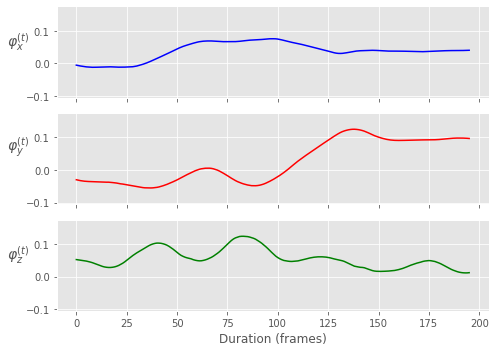

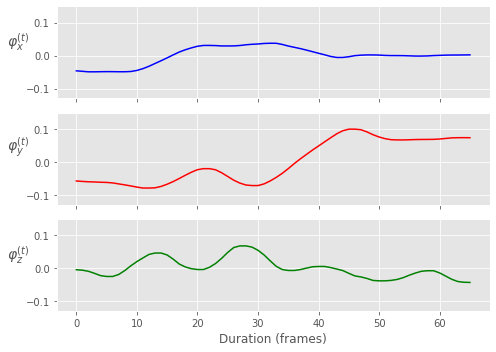

In [11]:
# Pick an example signal for visualization
x_sample, y_sample = X_train[1], y_train[1] # mnd
plot_gesture(x_sample, y_sample)
plot_gesture(pre.transform(x_sample), y_sample)

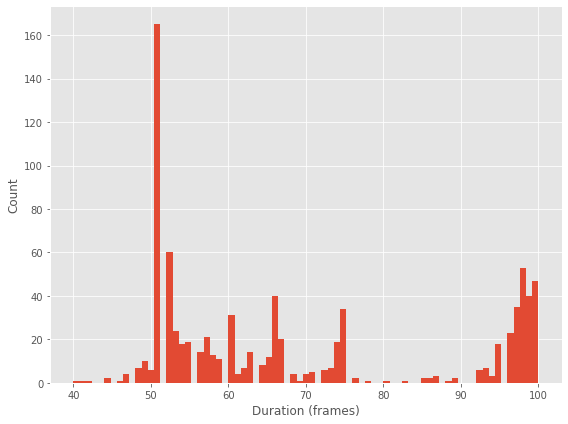

In [12]:
# Transform training data and plot histogram of MoCap dataset gesture durations (training set)
Xp_train = pre.fit_transform(X_train, verbose=True)
show_durations(Xp_train, bins=75, title=None)

In [13]:
# Apply the preprocessing pipeline to the other dataset splits
Xp_val, Xp_test = pre.transform(X_val, verbose=True), pre.transform(X_test, verbose=True)

## DTWKNN classifier

### Fitting the model

In [14]:
%%time
# Create and fit a DTWKNN classifier using the single nearest neighbor and a radius of 1
# NOTE: The radius parameter is a parameter that constrains the FastDTW algorithm.
clfs['knn'] = DTWKNN(k=1, radius=1)
clfs['knn'].fit(Xp_train, y_train)

CPU times: user 1.44 ms, sys: 180 µs, total: 1.62 ms
Wall time: 1.28 ms


### Evaluating the model

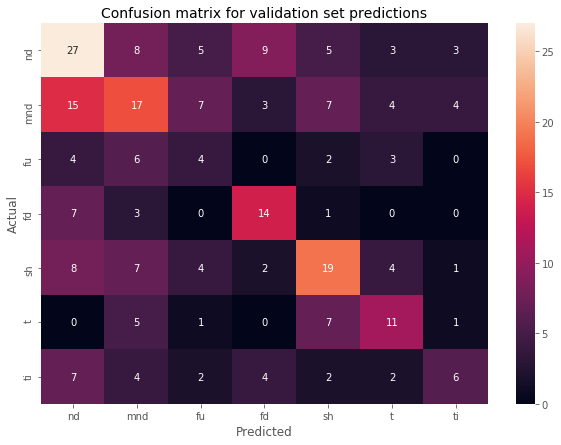

Accuracy: 37.98%
CPU times: user 675 ms, sys: 351 ms, total: 1.03 s
Wall time: 6min 36s


In [15]:
%%time
results['knn']['validation'] = clfs['knn'].evaluate(Xp_val, y_val, labels=gestures, n_jobs=-1)
show_results(*results['knn']['validation'], dataset='validation', labels=gestures)

## Hidden Markov Model classifier

One gesture model $\lambda_i=(A_i,B_i,\pi_i)$ is initialized and trained for each of the gestures: `nd`, `mnd`, `sh`, `fd`, `t`, `ti`, `fu`.

### Training the model

In [16]:
%%time

# Create HMMs to represent each class
#
# NumPy sometimes raises some errors as a result of instability during the Cholesky decomposition.
# According to issue #414 on Pomegranate's GitHub repository, this may be caused by:
# - Too many states in the HMMs
# - Too many dimensions in the input data, which leads to a large covariance matrix
# - Too few training examples
hmms = []
for g in tqdm(gestures, desc='Training HMMs'):
    hmm = HMM(label=g, n_states=7, random_state=rng)
    hmm.set_random_initial()
    hmm.set_random_transitions()
    hmm.fit([Xp_train[i] for i, label in enumerate(y_train) if label == g])
    hmms.append(hmm)
    
# Fit a HMM classifier with the HMMs
clfs['hmm'] = HMMClassifier()
clfs['hmm'].fit(hmms)


CPU times: user 1min 11s, sys: 0 ns, total: 1min 11s
Wall time: 1min 11s


### Evaluating the model

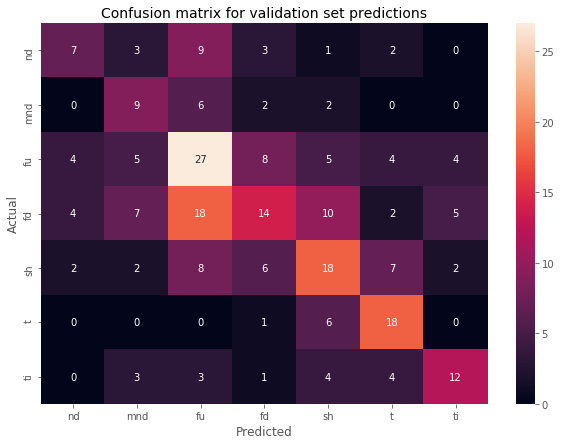

Accuracy: 40.70%
CPU times: user 786 ms, sys: 79.5 ms, total: 866 ms
Wall time: 685 ms


In [17]:
%%time
results['hmm']['validation'] = clfs['hmm'].evaluate(Xp_val, y_val)
show_results(*results['hmm']['validation'], dataset='validation', labels=gestures)

In [18]:
with np.printoptions(precision=3, suppress=True):
    display(hmms[0].initial)
    display(hmms[0].transitions)

array([0.253, 0.128, 0.133, 0.041, 0.042, 0.135, 0.268])

array([[0.952, 0.039, 0.002, 0.   , 0.   , 0.003, 0.004],
       [0.   , 0.96 , 0.001, 0.003, 0.001, 0.029, 0.007],
       [0.   , 0.   , 0.962, 0.021, 0.   , 0.013, 0.004],
       [0.   , 0.   , 0.   , 0.975, 0.015, 0.01 , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.984, 0.016, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.992, 0.008],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   ]])

## LSTM classifier

### Fitting the model

In [19]:
%%time
from tensorflow.keras.optimizers import Adam
clfs['lstm'] = LSTMClassifier(epochs=175, batch_size=128, optimizer=Adam(learning_rate=0.002), classes=gestures)
hist = clfs['lstm'].fit(Xp_train, y_train, validation_data=(Xp_val, y_val), return_history=True)

Train on 841 samples, validate on 258 samples
Epoch 1/175
841/841 [==============================] - 9s 11ms/sample - loss: 1.9153 - accuracy: 0.2128 - val_loss: 1.8614 - val_accuracy: 0.2326
Epoch 2/175
841/841 [==============================] - 3s 4ms/sample - loss: 1.8794 - accuracy: 0.2307 - val_loss: 1.8531 - val_accuracy: 0.2442
Epoch 3/175
841/841 [==============================] - 3s 3ms/sample - loss: 1.8397 - accuracy: 0.2473 - val_loss: 1.7884 - val_accuracy: 0.2597
Epoch 4/175
841/841 [==============================] - 3s 4ms/sample - loss: 1.8029 - accuracy: 0.2556 - val_loss: 1.7331 - val_accuracy: 0.3062
Epoch 5/175
841/841 [==============================] - 3s 4ms/sample - loss: 1.7647 - accuracy: 0.2652 - val_loss: 1.6682 - val_accuracy: 0.3566
Epoch 6/175
841/841 [==============================] - 3s 4ms/sample - loss: 1.7240 - accuracy: 0.2818 - val_loss: 1.6244 - val_accuracy: 0.3527
Epoch 7/175
841/841 [==============================] - 3s 4ms/sample - loss: 1.7068

In [20]:
# Summarize the model
clfs['lstm'].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100, 200)          83200     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 707       
Total params: 344,807
Trainable params: 344,807
Non-trainable params: 0
_________________________________________________________________


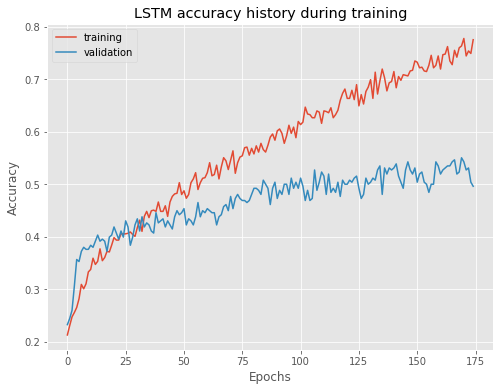

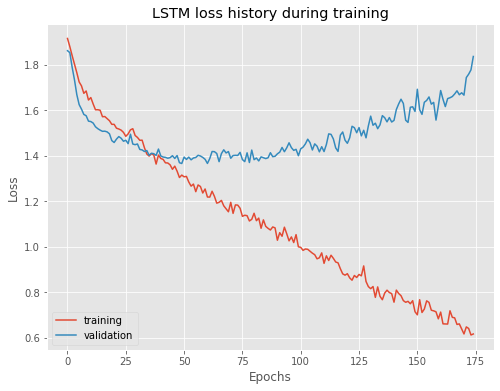

In [21]:
# Display accuracy and loss history during training
show_accuracy_history(hist)
show_loss_history(hist)

### Evaluating the model

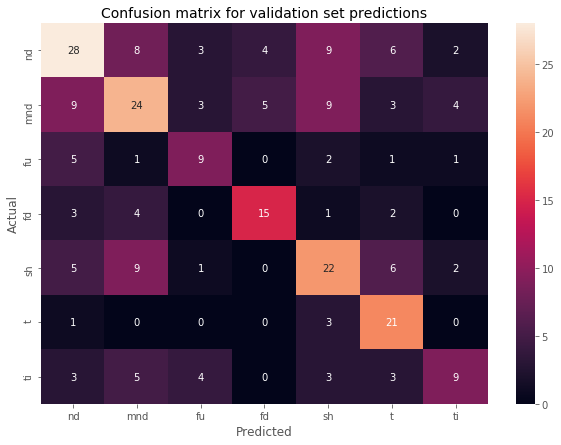

Accuracy: 49.61%
CPU times: user 1.95 s, sys: 355 ms, total: 2.3 s
Wall time: 967 ms


In [22]:
%%time
results['lstm']['validation'] = clfs['lstm'].evaluate(Xp_val, y_val)
show_results(*results['lstm']['validation'], dataset='validation', labels=gestures)